# Free Wave Packet Time Evolution

In this example we evolve a free wave packet in time. 

The module allows comparison of three numerical methods:

- Pseudo-Espectral
- Crank-Nicolson
- Runge-Kutta

We run a series of tests regarding to their precision and time cost.

## Libraries

Those are the necessary libraries.

In [57]:
# python standard
import time

# python extended
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()

# our libraries
from lib.free_wave_packet import FreeWavePacket

# default configurations
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20

## Moving between two points

We place a initial wave with energy $E = 150 \, eV$ and spread of $\sigma = 5 \, \unicode[serif]{xC5}$ at the position $-20 \, \unicode[serif]{xC5}$ and we apply the evolution operator until it achieves $+20 \, \unicode[serif]{xC5}$. The time steps are $\Delta t = 1 \times 10^{-19} \, s$, the system has size $L=100 \, \unicode[serif]{xC5}$, and it is divided into $N=2048$ points.

In [3]:
particle = FreeWavePacket()
numeric = particle.numerical_evolution(zi=-20.0, zf=20, E=150.0, deltaz=5.0, method='pe', L=100.0, N=2048, dt=1e-19)

The initial and final waves are pretty seemed as it is possible to see bellow.

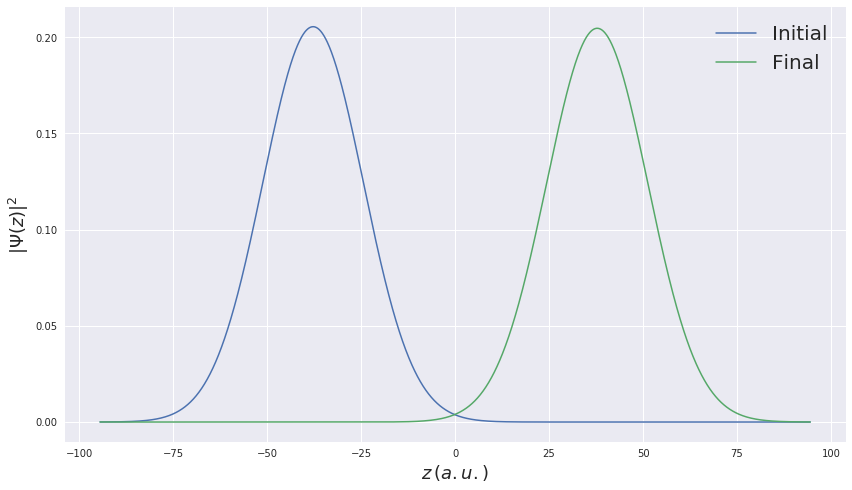

In [22]:
plt.xlabel('$z \, (a.u.)$')
plt.ylabel('$|\Psi(z)|^2$')
plt.plot(numeric['z_au'], np.abs(numeric['wave_initial']), label='Initial')
plt.plot(numeric['z_au'], np.abs(numeric['wave_final']), label='Final')
plt.legend()
plt.show()

The class `FreeWavePacket` provides the analytical solution also.

In [23]:
analytic = particle.analytical_evolution(zi=-20.0, zf=20, E=150.0, deltaz=5.0, L=100.0, N=2048)

Which has a very seemed response for those parameters.

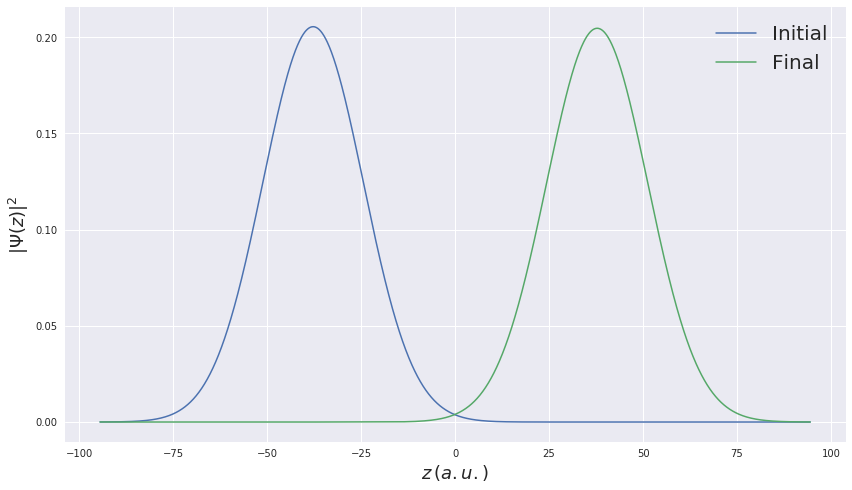

In [24]:
plt.xlabel('$z \, (a.u.)$')
plt.ylabel('$|\Psi(z)|^2$')
plt.plot(analytic['z_au'], np.abs(analytic['wave_initial']), label='Initial')
plt.plot(analytic['z_au'], np.abs(analytic['wave_final']), label='Final')
plt.legend()
plt.show()

The more interesting parameters on each solution are the final spread ($\sigma$), the skewness ($\gamma$) and the wave's mass consevation ($A/A_0$).

In [52]:
print("Numerical results:")
print("Skewness = %.2e" % numeric['skewness'])
print(r"Standard Deviation = %.4f A" % numeric['stdev'])
print("Mass Conservation = %.2f %%" % numeric['conservation'])
print('---')
print("Analytical results:")
print("Skewness = %.2e" % analytic['skewness'])
print(r"Standard Deviation = %.4f A" % analytic['stdev'])
print("Mass Conservation = %.2f %%" % analytic['conservation'])

Numerical results:
Skewness = -3.35e-06
Standard Deviation = 5.0405 A
Mass Conservation = 100.00 %
---
Analytical results:
Skewness = -3.34e-06
Standard Deviation = 5.0405 A
Mass Conservation = 100.00 %


The skewness in both case, even in the "analytical" solution, is due to numerical errors. Actually, the analytical said solution relies on a numerical integration.

## Testing methods, system length, number of points, and time steps

The following code generates the numerical along with the analytical solutions for the following parameters:

- Methods: Pseudo-Espectral (`pe`), Crank-Nicolson (`cn`), and Runge-Kutta (`rk`).
- Length: $\{ 100, 250, 400, 550, 700, 850, 100\} \, \unicode[serif]{xC5}$ 
- Number of points: $\{256, 512, 1024, 2048, 4096\}$
- Time steps: $\{ 1 \times 10^{-20}, 5 \times 10^{-20}, 1 \times 10^{-19}, 5 \times 10^{-19}, 1 \times 10^{-18}, 5 \times 10^{-18}, 1 \times 10^{-17}, 5 \times 10^{-17}, 1 \times 10^{-16}, 5 \times 10^{-16} \} \, s$ 

In [ ]:
methods = ['pe', 'cn', 'rk']
steps = [1e-20, 5e-20, 1e-19, 5e-19, 1e-18, 5e-18, 1e-17, 5e-17, 1e-16, 5e-16]
combinations = []

for method in methods:
    for L in np.linspace(100,1000,7):
        for N in [2**n for n in range(8,13)]:
            for dt in steps:
                if dt < 1e-19 and method != 'pe':
                    continue
                combinations.append((method, L, N, dt))

def evolve_comb(combination):
    try:
        method, L, N, dt = combination
        res = numerical_evolution(L=L, N=N, dt=dt, method=method)
        zf_real = res['zf_real']
        res_ana = analytical_evolution(zf=zf_real)

        for k in res_ana.keys():
            res[k + '_ana'] = res_ana[k]

        message = "%s: L=%d, N=%d, dt=%.2e, " + \
                    "A/A0=%.5f, S=%.4f, G=%.4f, " + \
                    "A/A0_ana=%.5f, S_ana=%.4f, G_ana=%.4f, " + \
                    "time=%.5f"
        message = message % (method, L, N, dt,\
            res['a'], res['stdvar'], \
            res['skew'], res['a_real'], \
            res['stdvar_real'], res['skew_real'],
            res['program_time'])
        logger.info(message)

        return res

    except Exception as err:
        logger.error("Falha em %s: L=%d, N=%d, dt=%.2e" % \
            (method, L, N, dt))
        logger.error(str(err))
        return {}

pool = Pool(processes=8)
results = pd.DataFrame(pool.map(evolve_comb, combinations))

pec = results.loc[results['method'] == 'pe']
cnc = results.loc[results['method'] == 'cn']
rkc = results.loc[results['method'] == 'rk']
pec.to_csv('assets/free_wave_packet_results_pec.csv')
cnc.to_csv('assets/free_wave_packet_results_cnc.csv')
rkc.to_csv('assets/free_wave_packet_results_rkc.csv')

The code above might take a day or two depending on your machine. Let's reload the files and scale the properties of interest, so that we can properly compare them.

In [72]:
# loading
pec = pd.read_csv('assets/free_wave_packet_results_pec.csv')
cnc = pd.read_csv('assets/free_wave_packet_results_cnc.csv')
rkc = pd.read_csv('assets/free_wave_packet_results_rkc.csv')

# scale results for quality indicator
scaler = StandardScaler()
cols = ['stdvar', 'skew', 'a', 'stdvar_real', 'skew_real', 'a_real']
pec[cols] = scaler.fit_transform(pec[cols])
rkc[cols] = scaler.fit_transform(rkc[cols])
cnc[cols] = scaler.fit_transform(cnc[cols])

We plot bellow the comparison between the three methods according to combinations of $\{ L, N, \Delta t\}$. It is shown how the Minkowski Distance of those three parameters of interest ($\sigma$, $\gamma$, $A/A_0$) behave according to the program time cost.

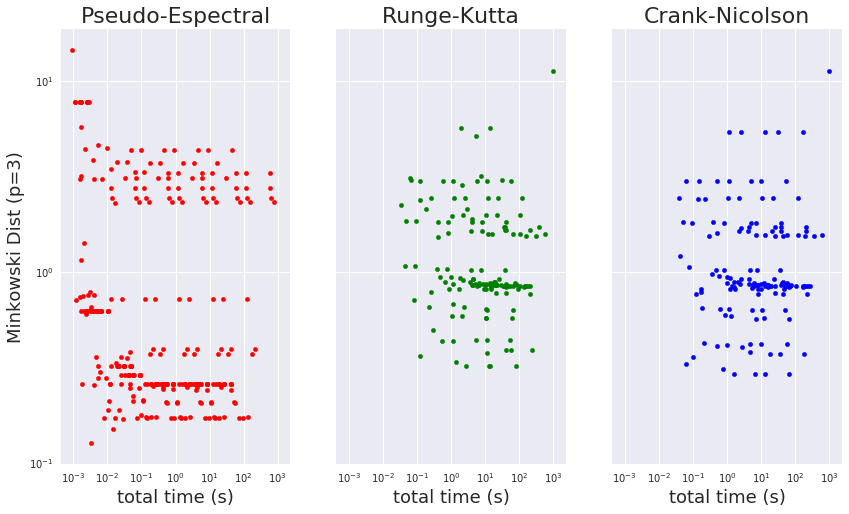

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
with pd.plotting.plot_params.use('x_compat', True):
    def minkowski(line, p=3):
        x_num = [[line['stdvar'], line['skew'], \
            line['a']]]
        x_ana = [[line['stdvar_real'], line['skew_real'], \
            line['a_real']]]
        dist = cdist(XA=x_num, XB=x_ana, metric='minkowski', p=p)
        return dist[0][0]

    pec['minkowski'] = pec.apply(minkowski, axis=1)
    pec.plot(x='program_time', y='minkowski', kind='scatter', \
        loglog=True, color='r', ax=ax1)

    rkc['minkowski'] = rkc.apply(minkowski, axis=1)
    rkc.plot(x='program_time', y='minkowski', kind='scatter', \
        loglog=True, color='g', ax=ax2)

    cnc['minkowski'] = cnc.apply(minkowski, axis=1)
    cnc.plot(x='program_time', y='minkowski', kind='scatter', \
        loglog=True, color='b', ax=ax3)

ax1.title.set_text('Pseudo-Espectral')
ax2.title.set_text('Runge-Kutta')
ax3.title.set_text('Crank-Nicolson')
ax1.set_ylabel('Minkowski Dist (p=3)')
ax2.set_ylabel('Minkowski Dist (p=3)')
ax3.set_ylabel('Minkowski Dist (p=3)')
ax1.set_xlabel('total time (s)')
ax2.set_xlabel('total time (s)')
ax3.set_xlabel('total time (s)')
plt.show()

So, we can see that the Pseudo-Espectral method is a way superior, it has lots of combinations $\{ L, N, \Delta t\}$ under $0.1 \, s$ and under Minkowski Distance of $1$.

## Conclusion

The Pseudo-Espectral performs much better than the Runge-Kutta and Crank-Nicolson ones. It still has some down sides like its inability of properly dealing with an effective mass that changes accross the $z$ direction, but the precision and time cost are leading.